Created on 2025, Oct 14.

Description: Implementation of Stacked Periodograms, along with compilation of Lomb-Scargle algorithms.

**@authors:**

 - Cleber Silva < _clebersilva@fisica.ufc.br_ > [1, 3]

 - Eder Martioli < _emartioli@lna.br_ > [2, 3]

[1] Stellar Team - Universidade Federal do Ceará, Brazil.

[2] Laboratório Nacional de Astrofísica, Brasil.

[3] MALTED research group, Brazil.

**References:**

A. Mortier, A. Collier Cameron. A&A 601 A110 (2017) - DOI: https://doi.org/10.1051/0004-6361/201630201

A. Mortier, et al. A&A, 573 (2015) A101 - DOI: https://doi.org/10.1051/0004-6361/201424908

Jacob T. VanderPlas 2018 ApJS 236 16 - DOI: https://doi.org/10.3847/1538-4365/aab766

# Setup

In [55]:
from astropy.io import ascii
import LS_like_periodograms as aux
import matplotlib.pyplot as plt
import numpy as np

We must load the data and separate each type.

In [2]:
file = 'DS1_timeSeries.csv'
table = ascii.read(file)

time = table['Time [eMJD]'].value
RV = table['RV [m/s]'].value
RV_error = table['RV Err. [m/s]'].value

# RV plots

In this section, I show show the intuition behind how the algorithm selects the firt N data poinsts from the original time series. First, lets consider the whole RV curve.

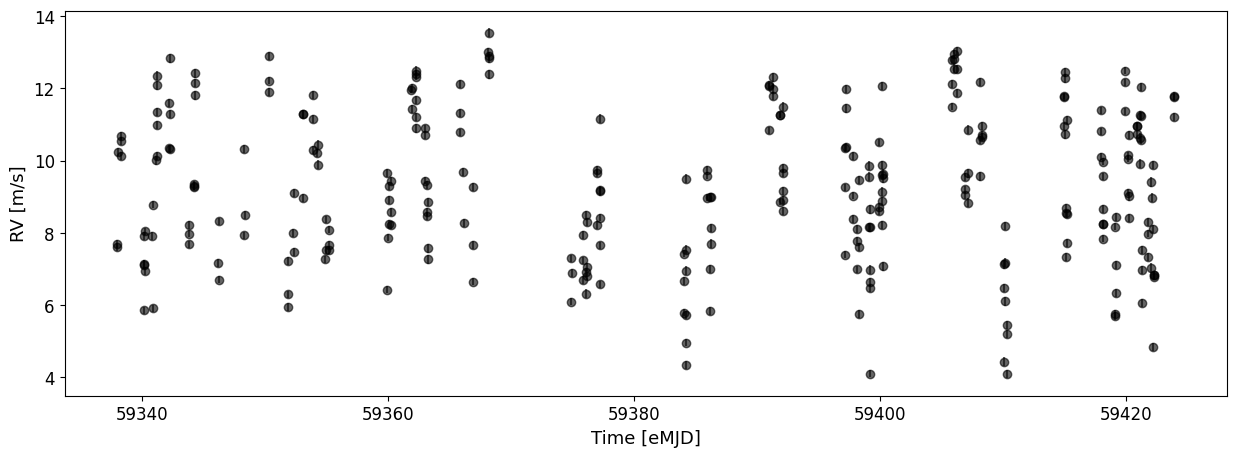

In [3]:
plt.figure(figsize = (15, 5))
plt.errorbar(time, RV, RV_error, fmt='o', color='k', alpha=0.6)
plt.xlabel("Time [eMJD]", fontsize = 13)
plt.ylabel("RV [m/s]", fontsize = 13)
plt.tick_params(axis='both', labelsize=12)
plt.show()

Now we can select `num_points` data points to analyse. We can select the `chronological` mode to select the first points in ascending time order. For this cuttet set, we can use plot the resulting curve and periodogram as folows.

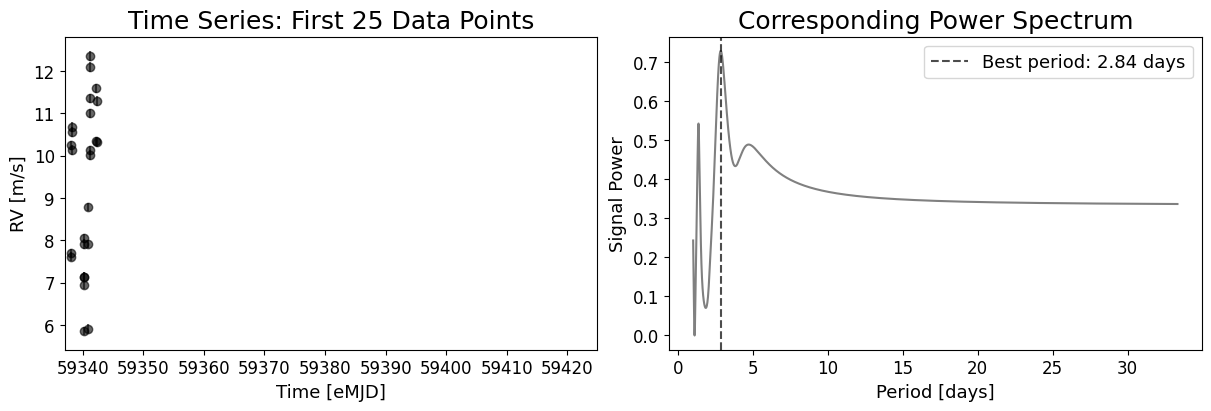

In [6]:
aux.plot_curve_and_periodogram(time, RV, RV_error, num_points=25,
                               periodogram_type='GLS', mode='chronological',
                               fixed_window=True);

We can also select `num_points` random data points to analyse with the `random` mode. In this way, the algorithm selects random points from all the timespan of the time series, while preserving their chronological order.

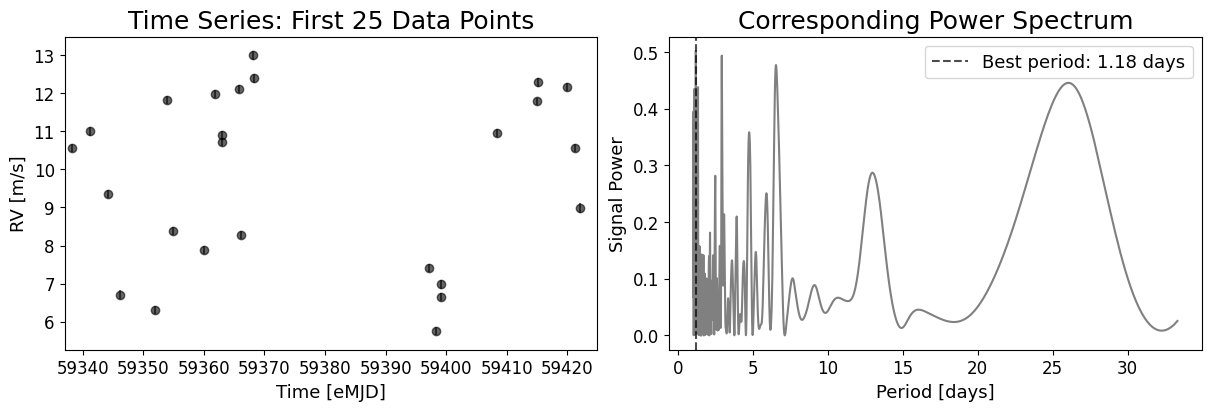

In [8]:
aux.plot_curve_and_periodogram(time, RV, RV_error, num_points=25,
                               periodogram_type='GLS', mode='random',
                               fixed_window=True);

Due to the seedless random functions, we get a different result each time the same command is executed. Also, `plot_curve_and_periodogram` allows us to store the resulting data from the cut. We can save it in a variable.

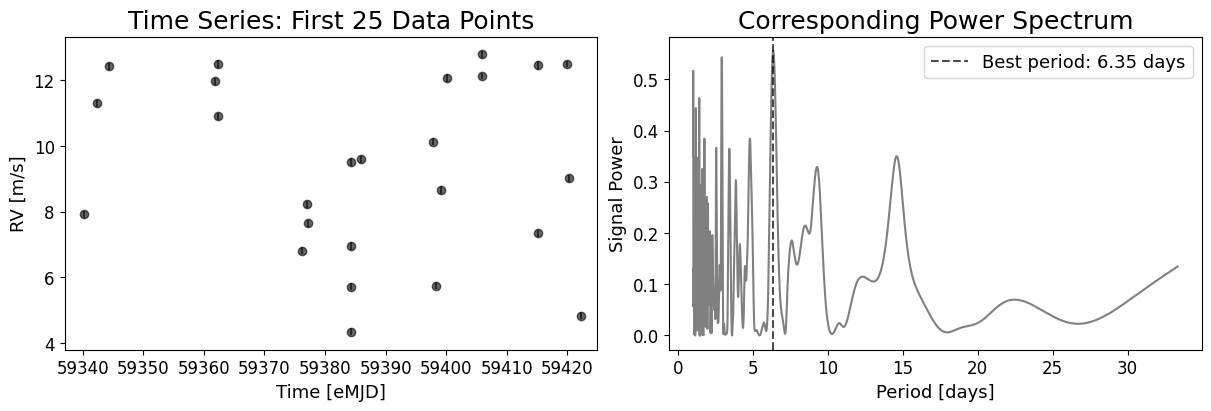

In [10]:
output = aux.plot_curve_and_periodogram(time, RV, RV_error, num_points=25,
                                        periodogram_type='GLS', mode='random',
                                        fixed_window=True)

We can then use this data to suplement a new execution. This is particularly usefull when we want to select new random data points from our full time series without losing the information about the previous run. The output dictionary has a mask of IDs of the time series points that where already selected. If we pass this mask, the code will first select all the indicated points and then will select `num_points` - `len(output['idxs_masks'])` new random data points. We can visually see this with the command below, where we are using the `output` dictionary from the preevious cell.

In this case, we now want 35 data points, but since we already selected 25 points on the previous execution, we algorithm will only select 10 new points.

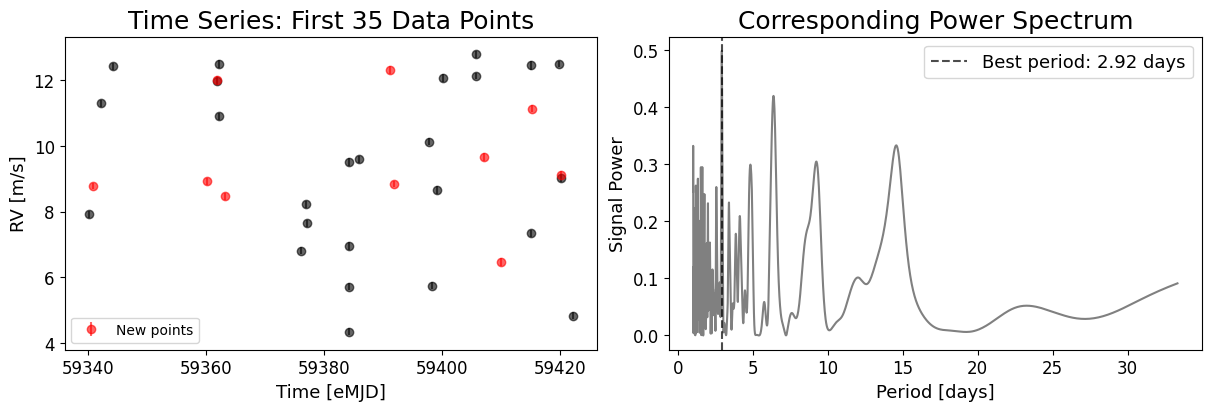

In [11]:
aux.plot_curve_and_periodogram(time, RV, RV_error, num_points=35, periodogram_type='GLS',
                               mode='random', old_idxs_mask=output['idxs_masks']);

As expected, we can runs the same code again to see that the red dots change at each execution, but not the gray dots, which are the previus selescted time series pointstime series points.

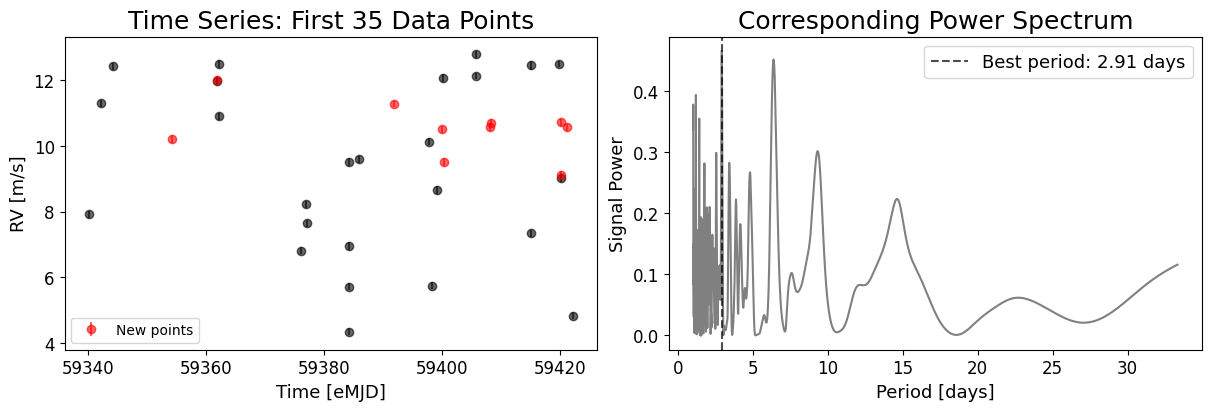

In [13]:
aux.plot_curve_and_periodogram(time, RV, RV_error, num_points=35, periodogram_type='GLS',
                               mode='random', old_idxs_mask=output['idxs_masks']);

It is totally different result in the cut to do this by selecting 35 points from the very beggining. But see that the 35-points periodograms all agree with the highest power period.

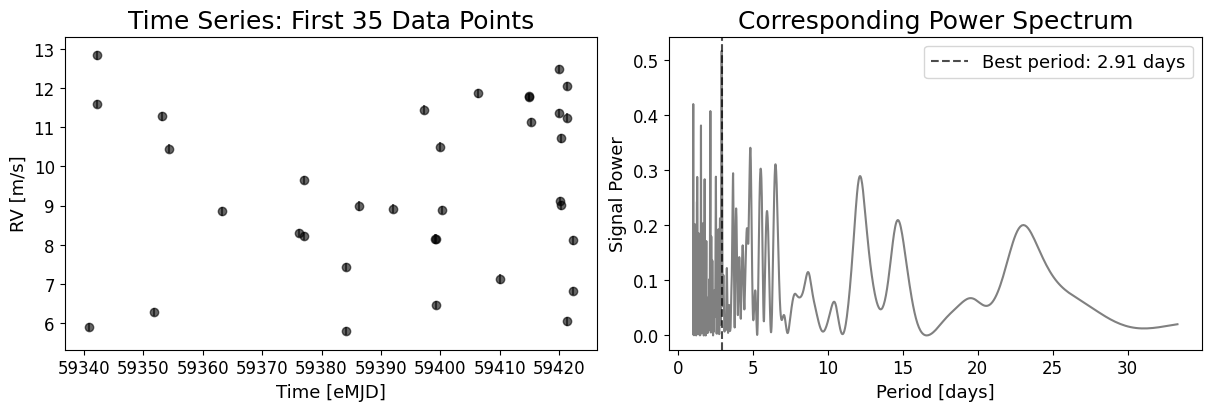

In [16]:
output2 = aux.plot_curve_and_periodogram(time, RV, RV_error, 35, periodogram_type='GLS', mode='random')

Finaly, we used the Generalised Lomb-Scargle (GLS) periodogram in all examples, but we can also use the Bayesian GLS (BGLS) periodogram in the same way. Its use is recommended with weak signals.

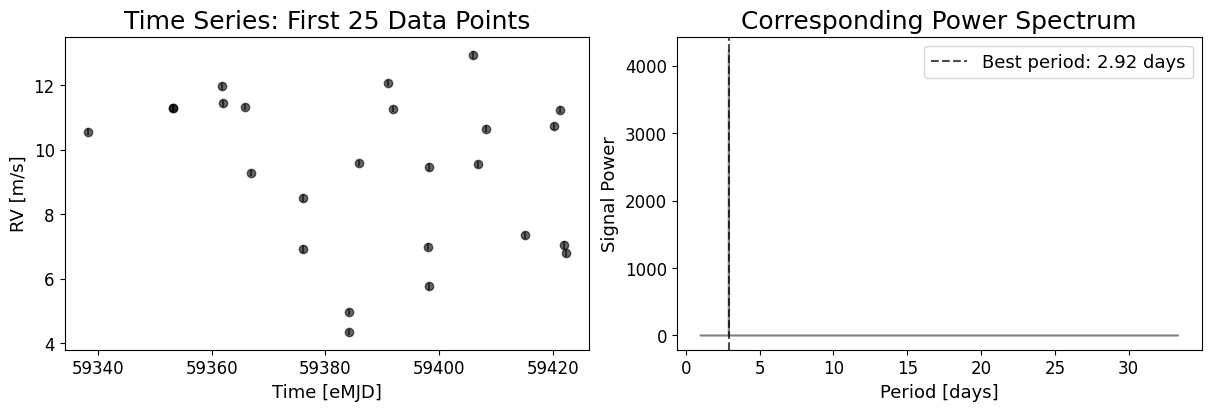

In [24]:
output2 = aux.plot_curve_and_periodogram(time, RV, RV_error, 25, periodogram_type='BGLS',
                                         mode='random')

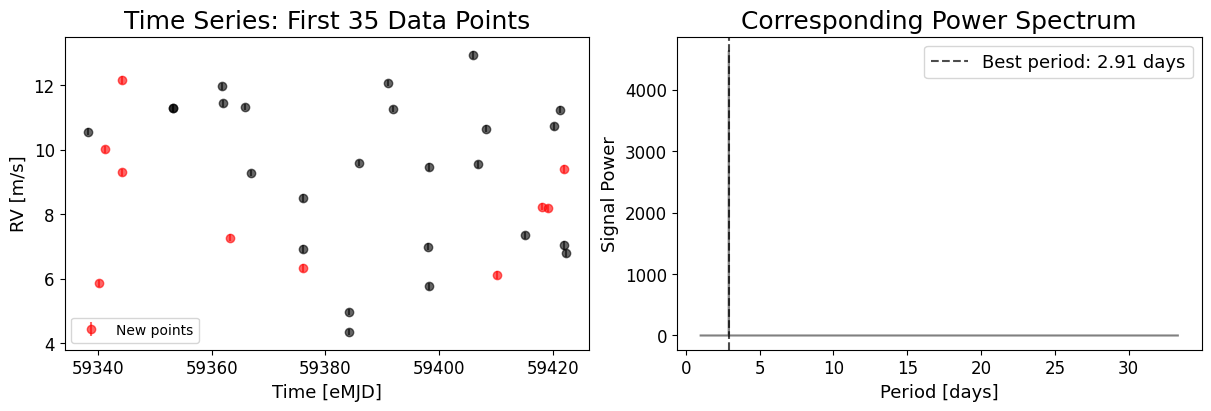

In [25]:
aux.plot_curve_and_periodogram(time, RV, RV_error, 35, periodogram_type='BGLS',
                               mode='random', old_idxs_mask=output2['idxs_masks']);

# Stacked Plots

Once we understand the selection od the time series points, we now can look at how we can _stack_ the periodograms results for each cut. The idea is simple: we start by selecting a fraction of the total data points from the time series by any mode, calculate the periodogram for it, store, and repeaditly increase one by one the number of selected data points to perform the same task until we select all the time series data points. Then we stack the results and plot a heat map for the number of observations (number of data points) as a funtion of the period. The color intensity of the heatmap is the periodogram's power.

## Chronological Sampling Analysis

In the `stacked_periodogram` function, we have many options for calculating the stacked periodogram. As a firts example, we are selecting the minimum and maximum range of periods to be considered, and also the number of periods within that interval. We start by selecting the first 50 data points in chronological order using GLS.

In [28]:
results = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                  periodogram_type='GLS', p_min=1,
                                  p_max=5, num_periods = 5000,
                                  mode='chronological')

100%|██████████| 238/238 [00:00<00:00, 338.29it/s]


We can pass the `results` dictionary to the `plot_stacked_periodogram_heatmap` function to plot the stacked periodogram. This function allows to select a normalization scheme, and we are going with the `linear` option.

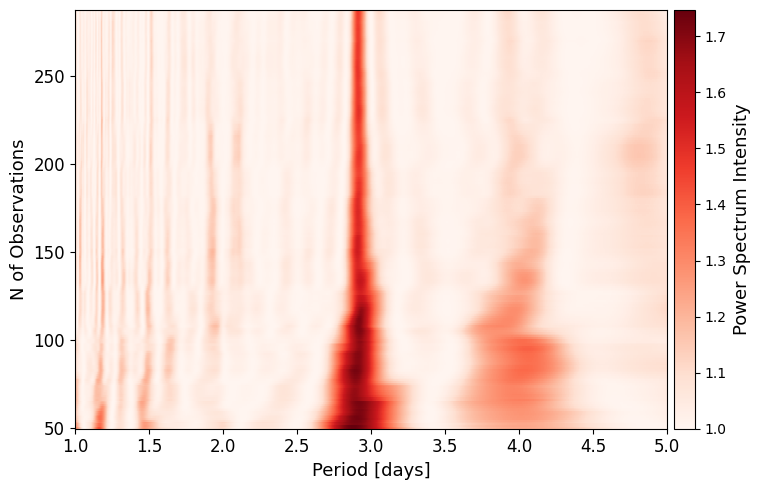

In [29]:
aux.plot_stacked_periodogram_heatmap(results, norm='linear')

We can also plot highlight the best period at each number of observation and plt the Signal-to-Noise Ratio (SNR) as a function of the number of observations.

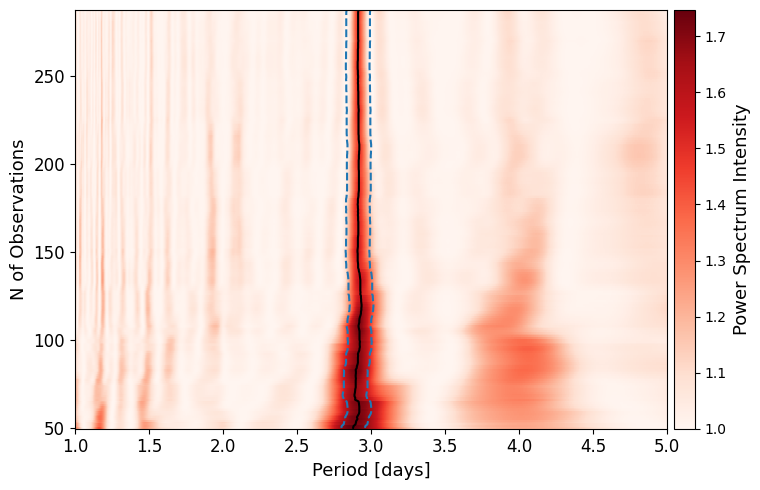

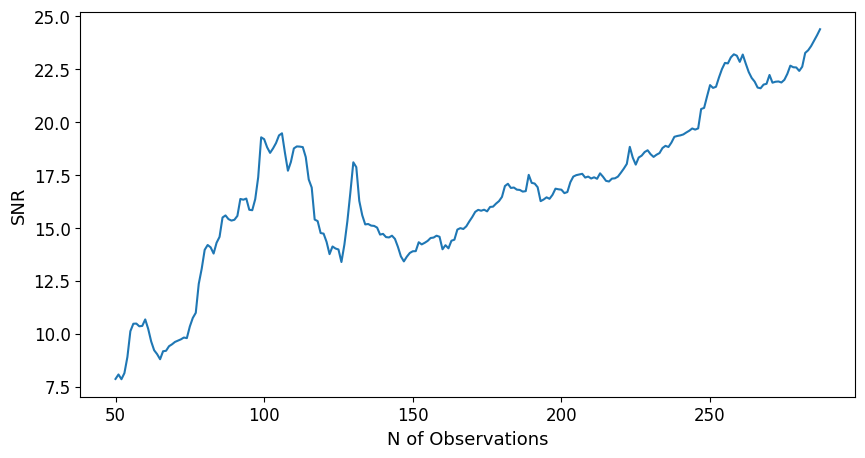

In [30]:
aux.plot_stacked_periodogram_heatmap(results, norm='linear', plot_SNR=True)

This signal is strong enough to make the black baseline to be approximatly straight, but there will be cases where we want to study the SNR for a specifc period value. This is done by spacifying a value for `base_P`. As a firts example, we can select the `optimal` option, where the algorithm will calculate the median value of the best periods in the black baseline from before.

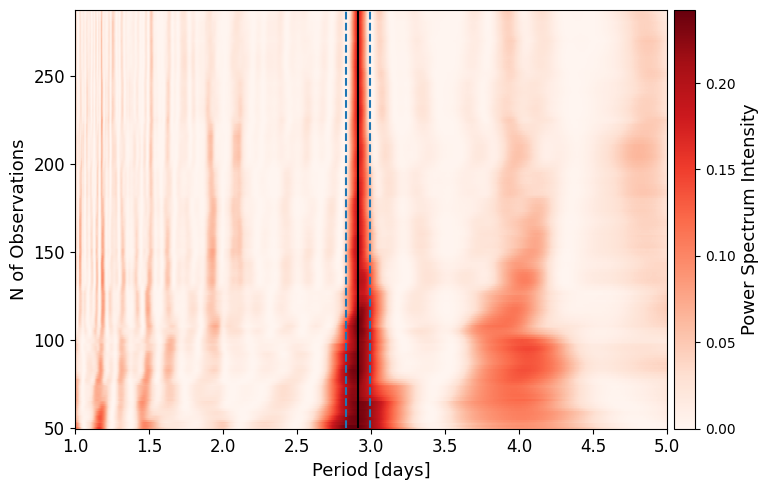

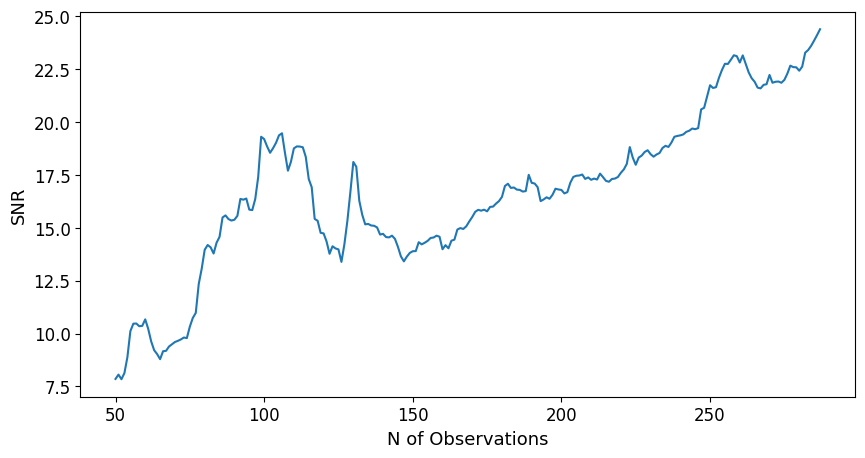

In [32]:
aux.plot_stacked_periodogram_heatmap(results, norm='log', plot_SNR=True, base_P='optimal')

We can also change the window considered when calculating the SNR using the parameter `delta_P`. Have in mind that `base_P` will be the central value in this window.

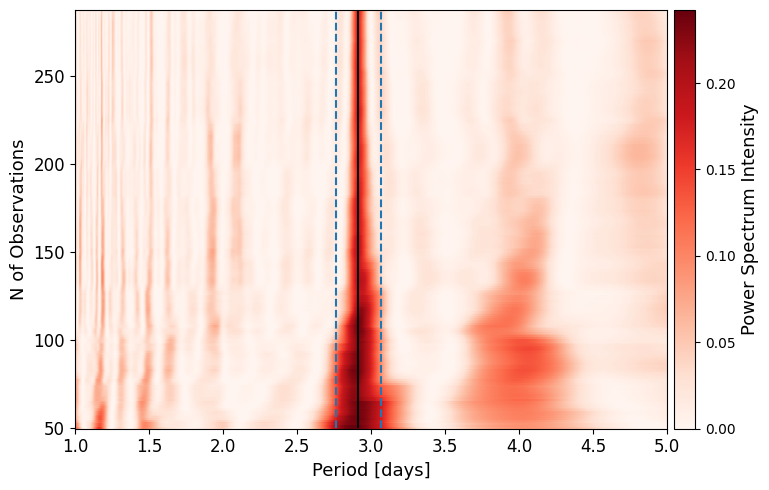

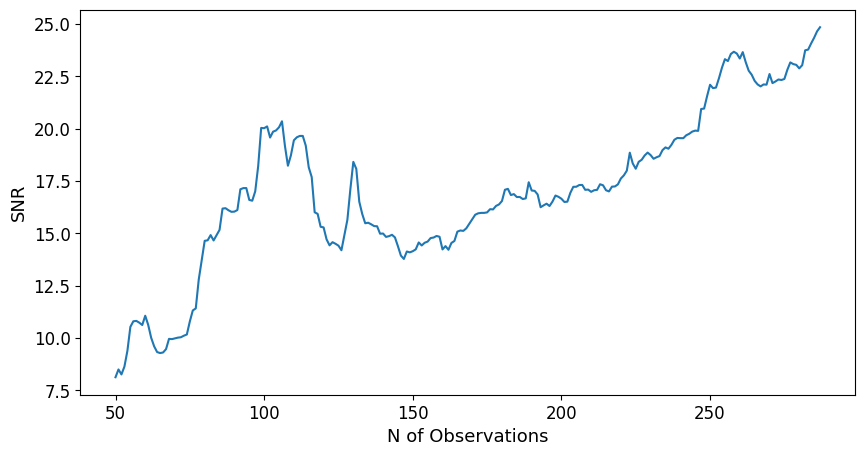

In [36]:
aux.plot_stacked_periodogram_heatmap(results, norm='log', plot_SNR=True, base_P='optimal', delta_P=0.15)

A non-symmetrical window can also be considered. For that, we can pass a two-element array for `delta_P`, where we specify the left and right distance from the `base_P` value.

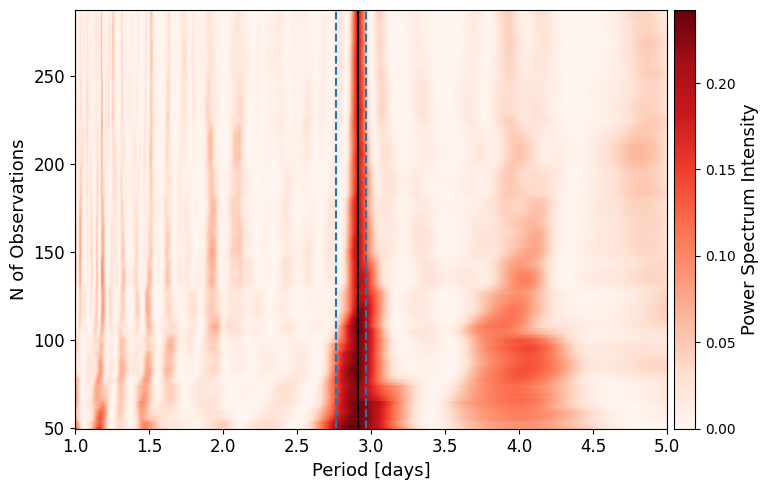

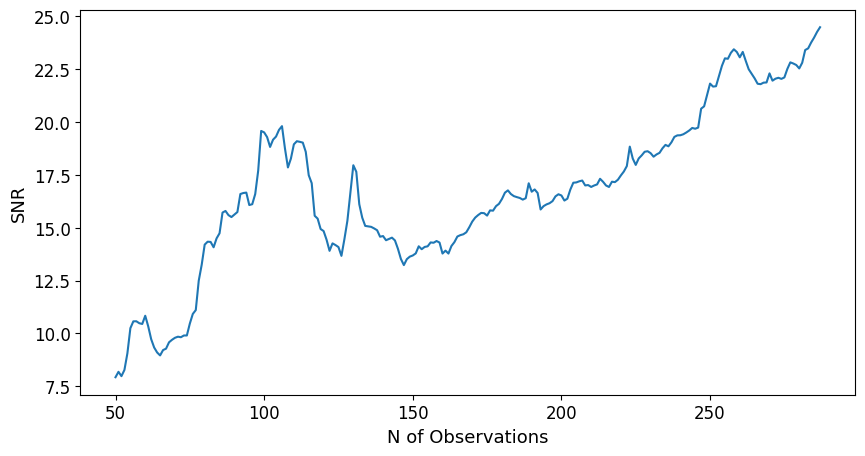

In [37]:
aux.plot_stacked_periodogram_heatmap(results, norm='log', plot_SNR=True, base_P='optimal', delta_P=(0.15, 0.05))

We can also consider other region to analyse by explicitly passing a value to `base_P`.

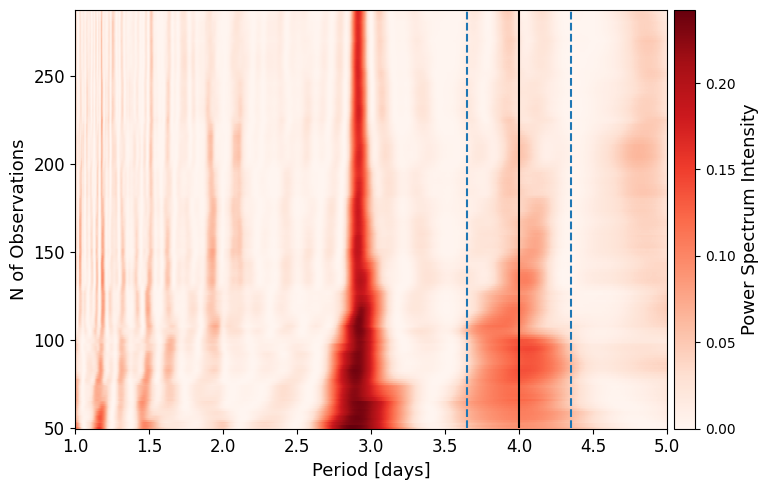

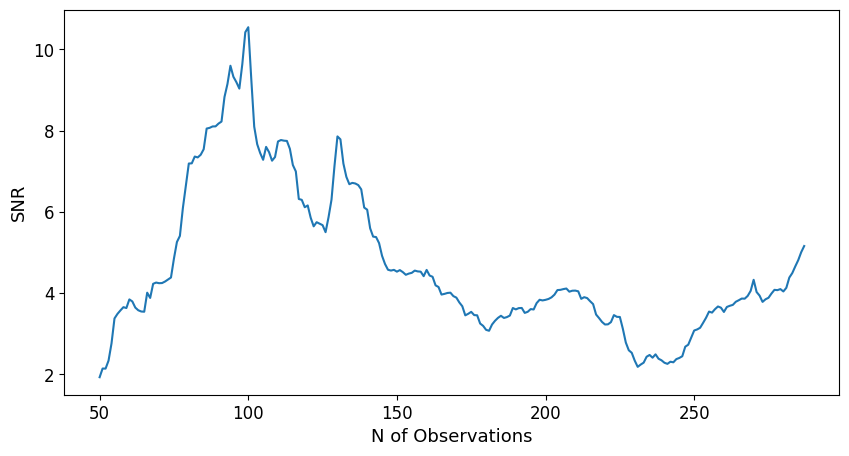

In [43]:
aux.plot_stacked_periodogram_heatmap(results, norm='log', plot_SNR=True, base_P=4.0, delta_P=0.35)

## Random Sampling Analysis

By changind the `mode` parameter to `random`, we can see a significant increase in the sharpness of the details since from the bottom of the stack. This is because the algorithm is now considering, on average, all the temporal extent of the time series, so dispesion effects with few chronological observations are mitigated.

In the `chronological` mode, the Number of observations was directly related to the time evolution itself. However, with the `random` mode. Virtually all time interval is being considering and the number of observations is now more related to the resolution of the time series.

In [44]:
results2 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                   periodogram_type='GLS', p_min=1,
                                   p_max=5, num_periods = 5000,
                                   mode='random')

100%|██████████| 238/238 [00:00<00:00, 278.08it/s]


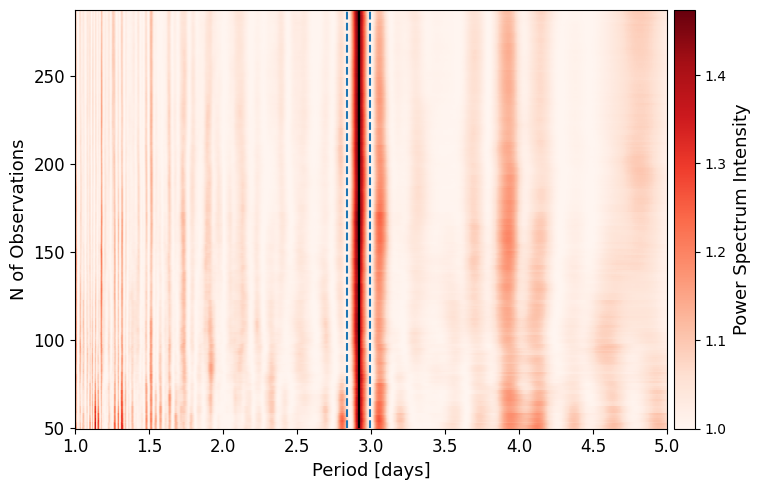

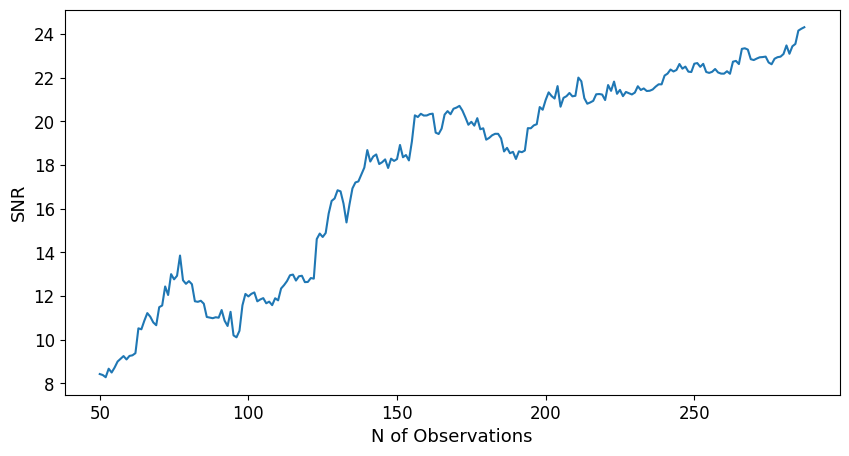

In [48]:
aux.plot_stacked_periodogram_heatmap(results2, norm='linear', plot_SNR=True, base_P='optimal')

In [46]:
results3 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                   periodogram_type='GLS', p_min=1,
                                   p_max=5, num_periods = 5000,
                                   mode='random without replacement')

100%|██████████| 238/238 [00:00<00:00, 317.79it/s]


There is another random method not discussed in the previous sections, which is the `random without replacement` mode. In the **RV Plots** section, we discussed how selecting a fixed mask prevents the randomness of the algoritm to affect the previous selected data points in a way that only the remaining data points were selected at random. The `random` mode does not care if it is selecting the same points when a new number of observation is allowed. This is not the case with the `random without replacement` (therefore the name). In sort, it will keep tack of the previous selected points so it can only randomly select a new point that was not previously been considered.

The immediate effect we see in comparison with the `random` mode is a more stable, almost linear, SNR growth of our signal.

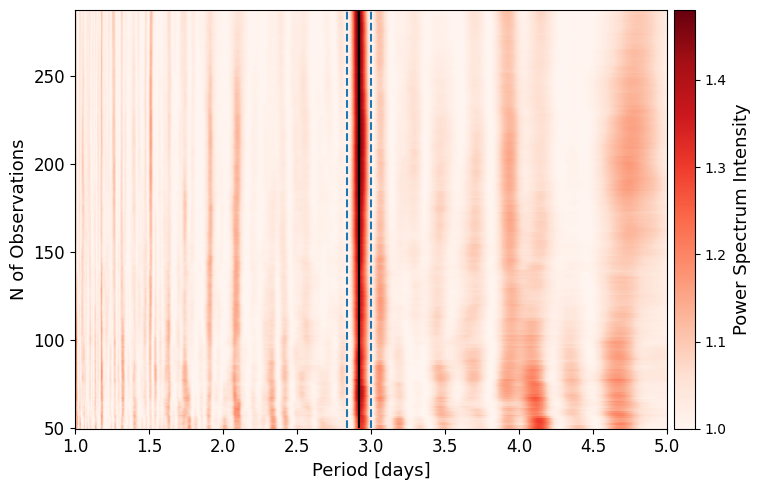

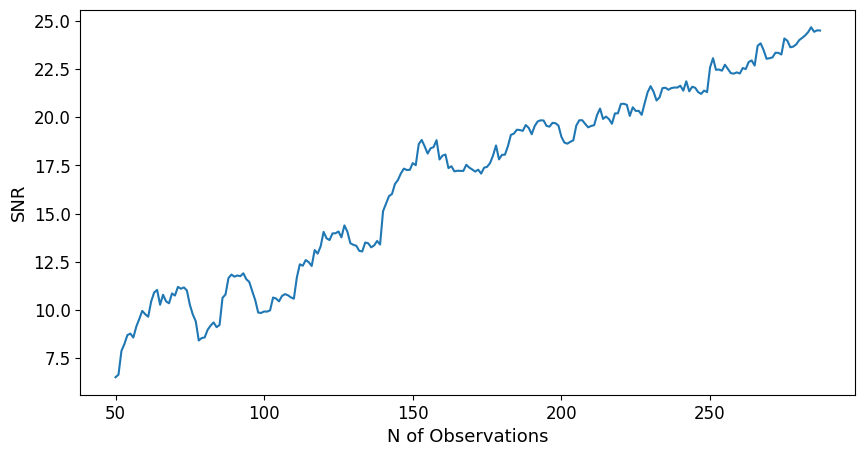

In [50]:
aux.plot_stacked_periodogram_heatmap(results3, norm='linear', plot_SNR=True, base_P='optimal')

## Mean Stacked Analysis

### Introduction

As a final greater functionality of the code (at this version), we can calculate the mean over a desired number of stacks. In sort, we perform `iterations` number of stacks, then we take the element-wise mean of each arrays value of them. The resulting stack is the one now being plotted.

To do this, we simply have to define a integer number greater than 0 for the `iterations` parameters. The result is smoother than the previous stacks and the SNR variation is lower, but this is due the fact that is starts higher than the other cases.

This functionality is only usefull for any of the random cases, since they can introduce diversity among stacks. The `chronological` case is not usefull here, in priciple, because all iterations gives the same result and the mean is not different from any individual stack.

In [51]:
results4 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                   periodogram_type='GLS', p_min=1,
                                   p_max=5, num_periods = 5000,
                                   mode='random', iterations=10)

100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


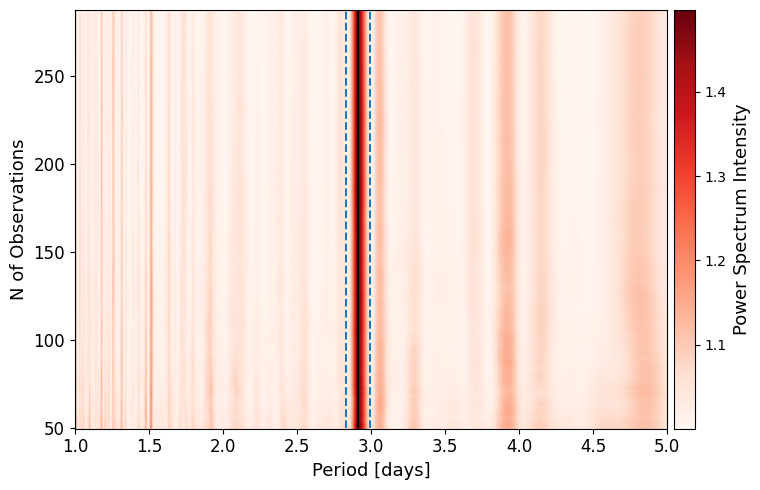

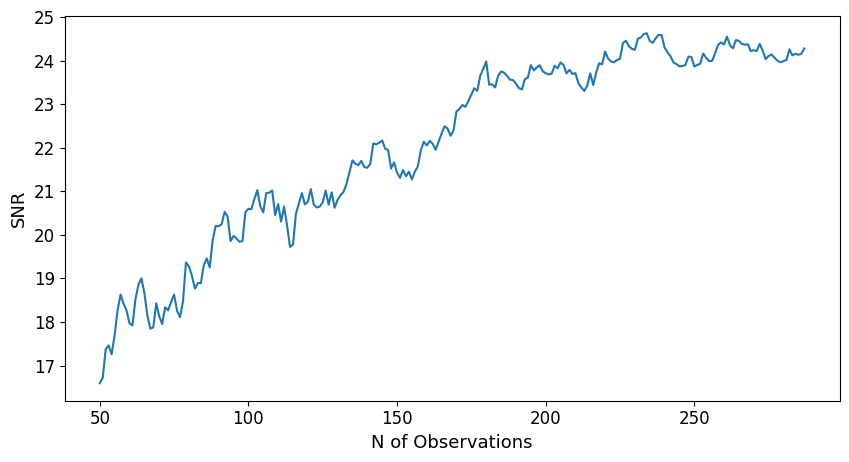

In [52]:
aux.plot_stacked_periodogram_heatmap(results4, norm='linear', plot_SNR=True, base_P='optimal')

we, of couse, can replicate this to the `random without replacement` mode. As a immediate result, we see also see a smoother stack but now the SNR plot is apparently not monotonic increasing.

In [53]:
results5 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                   periodogram_type='GLS', p_min=1,
                                   p_max=5, num_periods = 5000,
                                   mode='random without replacement', iterations=10)

100%|██████████| 10/10 [00:07<00:00,  1.25it/s]


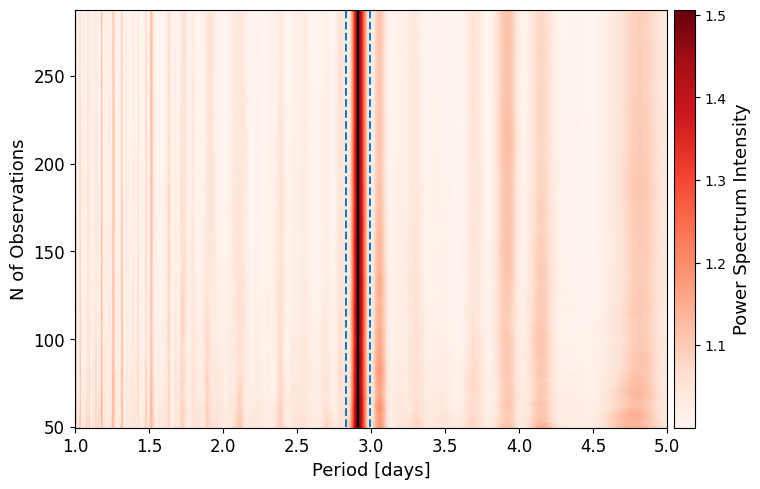

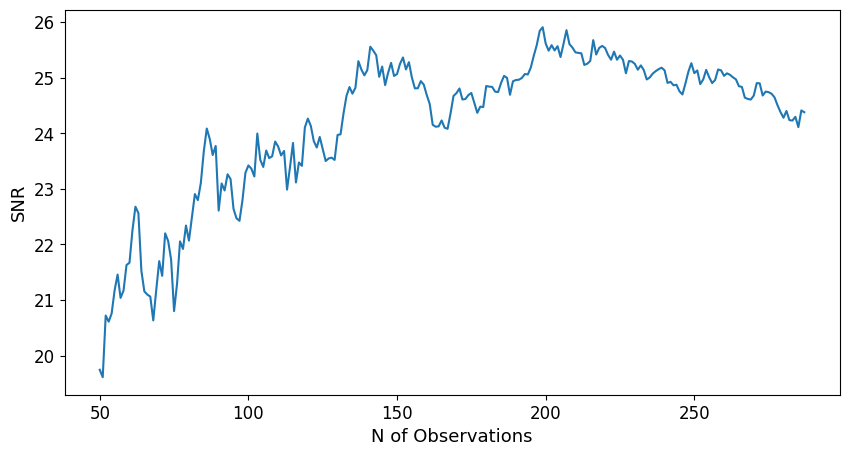

In [54]:
aux.plot_stacked_periodogram_heatmap(results5, norm='linear', plot_SNR=True, base_P='optimal')

There is also another opition to complement this mean stack, which relies on adding the `chronological` stack as one of the stacks considered in the mean. The order it is in the stack pile does not matter, but we added it as the first stack. To include it, we only need to set the parameter `first_mode_chronological` to `True`.

In [106]:
results6 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                   periodogram_type='GLS', p_min=1,
                                   p_max=5, num_periods = 5000,
                                   mode='random', iterations=10, first_mode_chronological=True)

100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


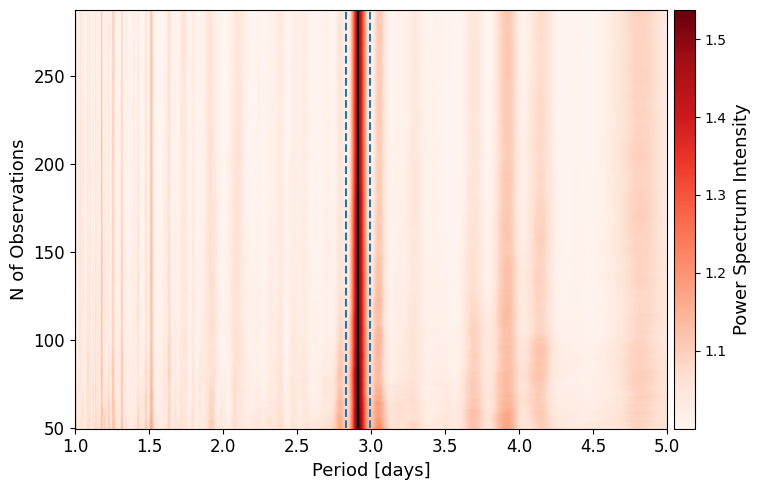

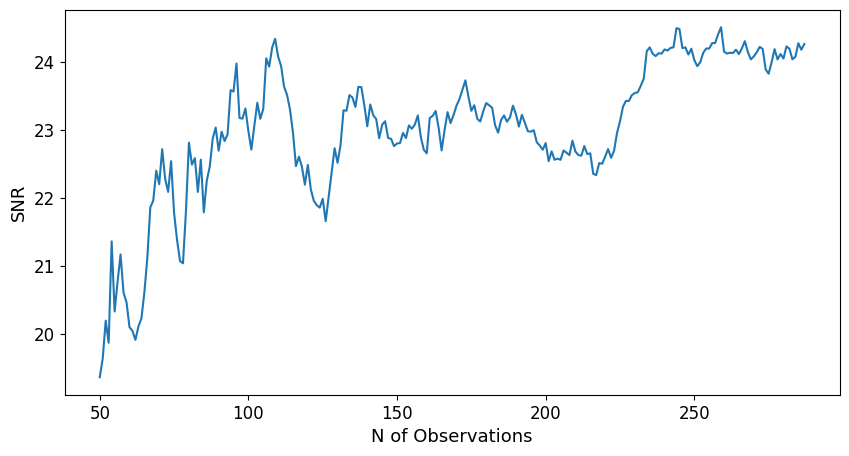

In [107]:
aux.plot_stacked_periodogram_heatmap(results6, norm='linear', plot_SNR=True, base_P='optimal')

In [108]:
results7 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                   periodogram_type='GLS', p_min=1,
                                   p_max=5, num_periods = 5000,
                                   mode='random without replacement',
                                   iterations=10, first_mode_chronological=True)

100%|██████████| 10/10 [00:08<00:00,  1.21it/s]


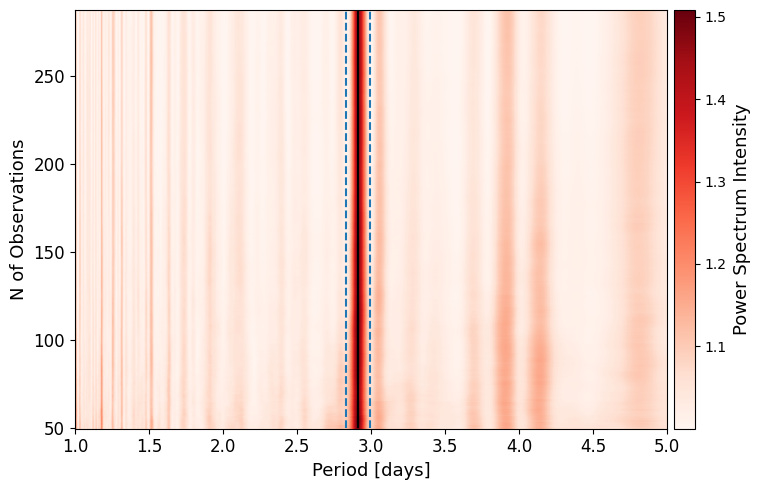

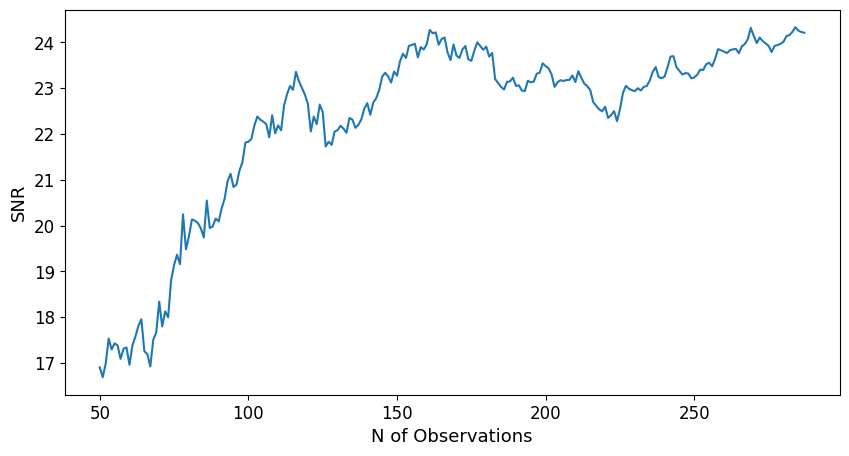

In [109]:
aux.plot_stacked_periodogram_heatmap(results7, norm='linear', plot_SNR=True, base_P='optimal')

By comparing these SNR plots with the previous cases, we see that adding the chronological stack introduces more noise to the plots and also adds some kind of transition in ~120 `N of Observations`.

### Mean Stack Depedence on the Number of Iterations

As a final analysis, we will look at the behaviour of the SNR of the mean stack as a function of the number of observations for many iterations values.

In [ ]:
SNR_random_arrays = {}

iteration_values = (1, 5, 15, 30, 60, 100)

for iteration_value in iteration_values:
    results8 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                       periodogram_type='GLS', p_min=1,
                                       p_max=5, num_periods = 5000,
                                       mode='random', iterations=iteration_value)
    best_P_array = results8['best_P_array']
    base_P = np.median(best_P_array)  # Optimal
    N_1D_array, SNR_random_array = aux.get_SNR(results8, delta_P=0.07, base_P=base_P)
    SNR_random_arrays[iteration_value] = SNR_random_array

100%|██████████| 100/100 [01:21<00:00,  1.23it/s]


The following plot shows the SNR as a function of the number of observations for many different number of iterations.

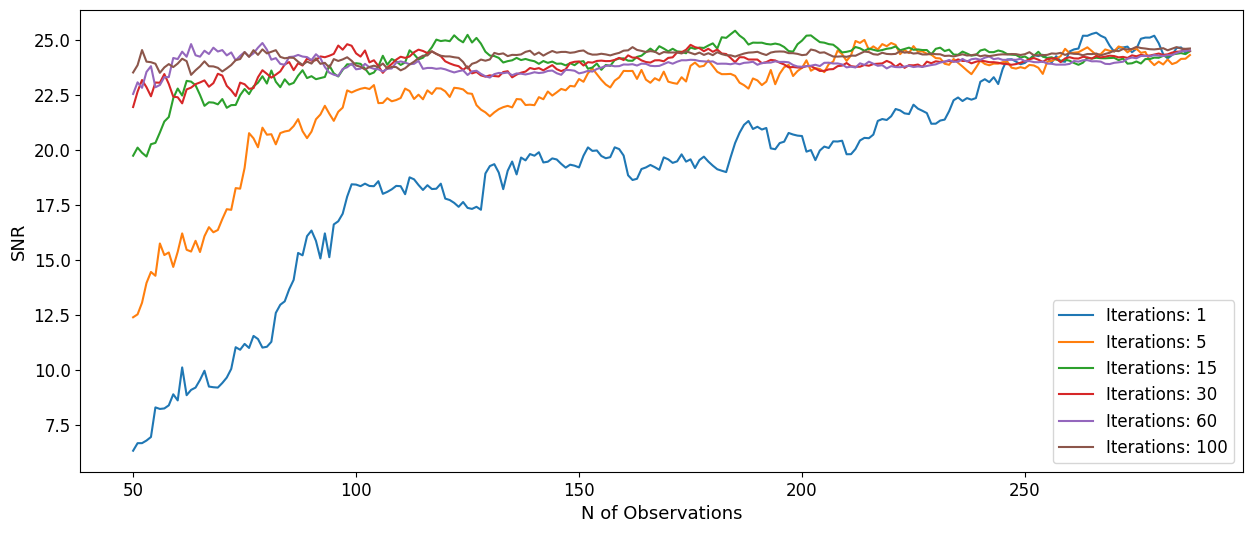

In [ ]:
plt.figure(figsize=(15, 6))
for i, key in enumerate(list(SNR_random_arrays.keys())):
    plt.plot(N_1D_array, SNR_random_arrays[key], label=f'Iterations: {key}', color=f'C{i}')
    coefs = np.polyfit(N_1D_array, SNR_random_arrays[key], deg=1)
    fit = N_1D_array*coefs[0] + coefs[1]
plt.xlabel("N of Observations", fontsize=13)
plt.ylabel("SNR", fontsize=13)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
plt.show()

The following plot shows the linear fit of the SNR as a function of the number of observations for many different number of iterations.

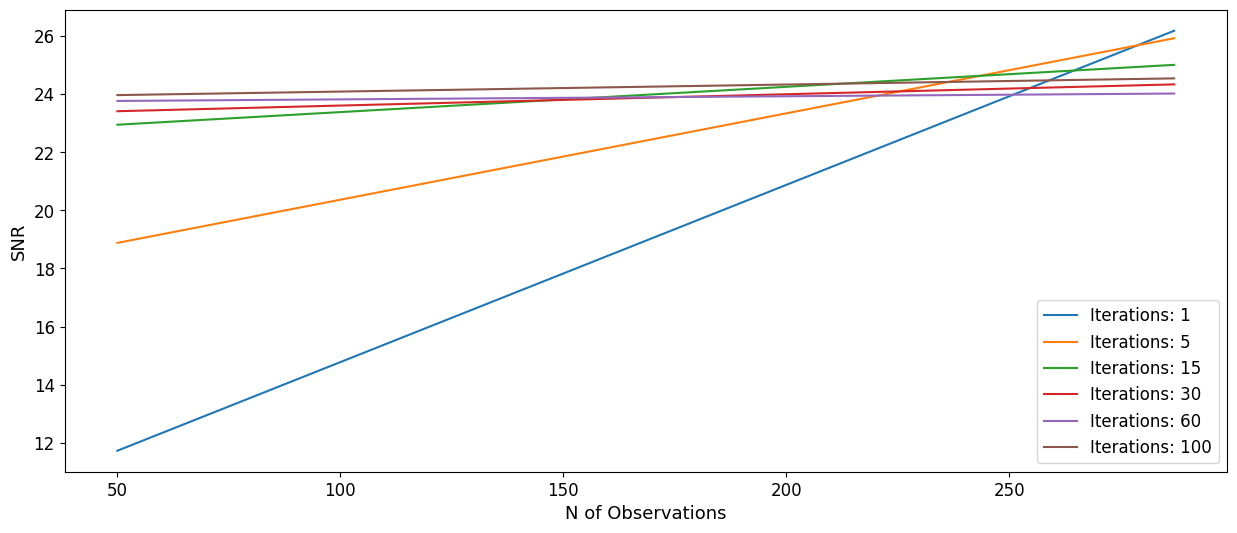

In [ ]:
plt.figure(figsize=(15, 6))
for i, key in enumerate(list(SNR_random_arrays.keys())):
    # plt.plot(N_1D_array, SNR_random_arrays[key], label=f'Iterations: {key}', color=f'C{i}')
    coefs = np.polyfit(N_1D_array, SNR_random_arrays[key], deg=1)
    fit = N_1D_array*coefs[0] + coefs[1]
    plt.plot(N_1D_array, fit, color=f'C{i}', label=f'Iterations: {key}')
plt.xlabel("N of Observations", fontsize=13)
plt.ylabel("SNR", fontsize=13)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
plt.show()

Now we do the same for the `random without replacement` mode case.

In [ ]:
SNR_random_no_replacement_arrays = {}

iteration_values = (1, 5, 15, 30, 60, 100)

for iteration_value in iteration_values:
    results9 = aux.stacked_periodogram(time, RV, RV_error, N_min=50,
                                       periodogram_type='GLS', p_min=1,
                                       p_max=5, num_periods = 5000,
                                       mode='random without replacement', iterations=iteration_value)
    best_P_array = results9['best_P_array']
    base_P = np.median(best_P_array)  # Optimal
    N_1D_array, SNR_random_no_replacement_array = aux.get_SNR(results9, delta_P=0.07, base_P=base_P)
    SNR_random_no_replacement_arrays[iteration_value] = SNR_random_no_replacement_array

100%|██████████| 100/100 [01:34<00:00,  1.06it/s]


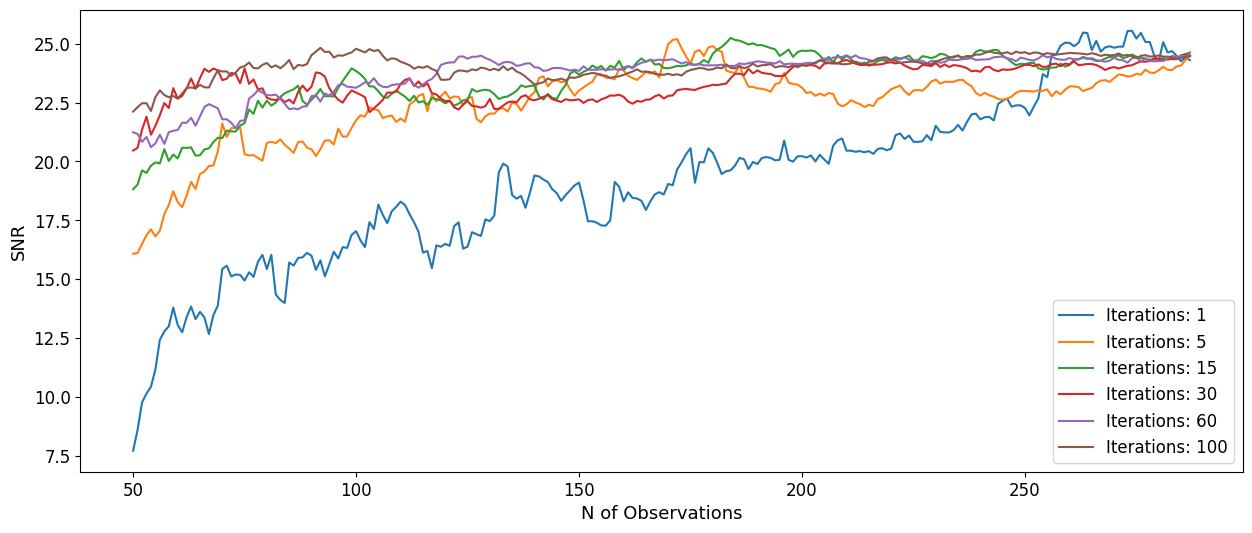

In [ ]:
plt.figure(figsize=(15, 6))
for i, key in enumerate(list(SNR_random_no_replacement_arrays.keys())):
    plt.plot(N_1D_array, SNR_random_no_replacement_arrays[key], label=f'Iterations: {key}', color=f'C{i}')
    coefs = np.polyfit(N_1D_array, SNR_random_no_replacement_arrays[key], deg=1)
    fit = N_1D_array*coefs[0] + coefs[1]
plt.xlabel("N of Observations", fontsize=13)
plt.ylabel("SNR", fontsize=13)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
plt.show()

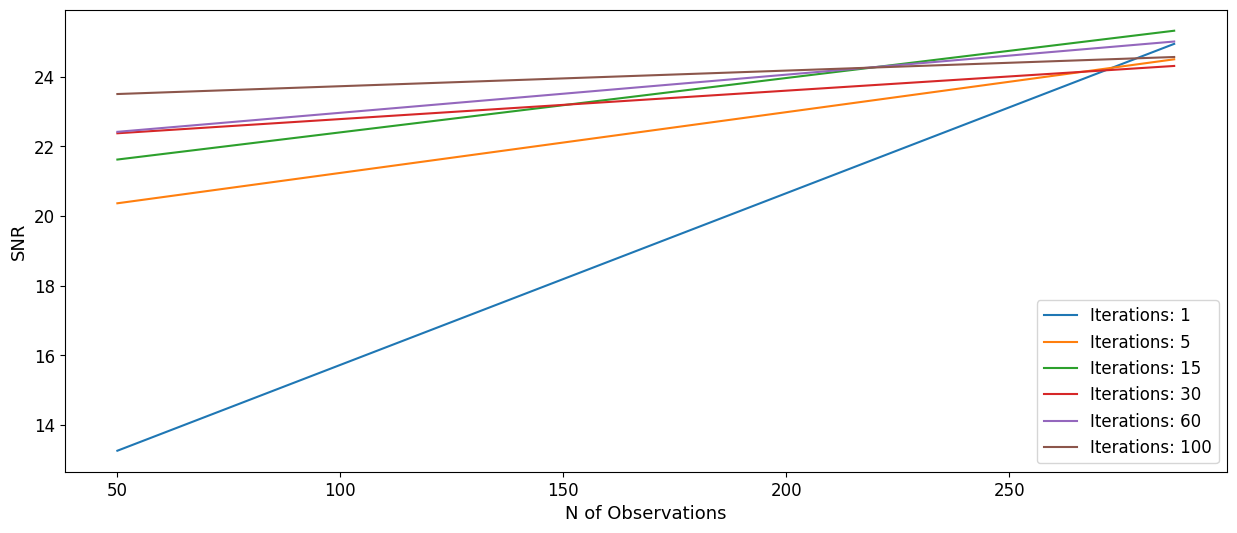

In [ ]:
plt.figure(figsize=(15, 6))
for i, key in enumerate(list(SNR_random_no_replacement_arrays.keys())):
    coefs = np.polyfit(N_1D_array, SNR_random_no_replacement_arrays[key], deg=1)
    fit = N_1D_array*coefs[0] + coefs[1]
    plt.plot(N_1D_array, fit, color=f'C{i}', label=f'Iterations: {key}')
plt.xlabel("N of Observations", fontsize=13)
plt.ylabel("SNR", fontsize=13)
plt.tick_params(axis='both', labelsize=12)
plt.legend(fontsize=12)
plt.show()

We can see that the `random` mode is slightly more stable than second case. From the linear fits, we can extract the linear variation rate for each case. Below is the plot comparing them.

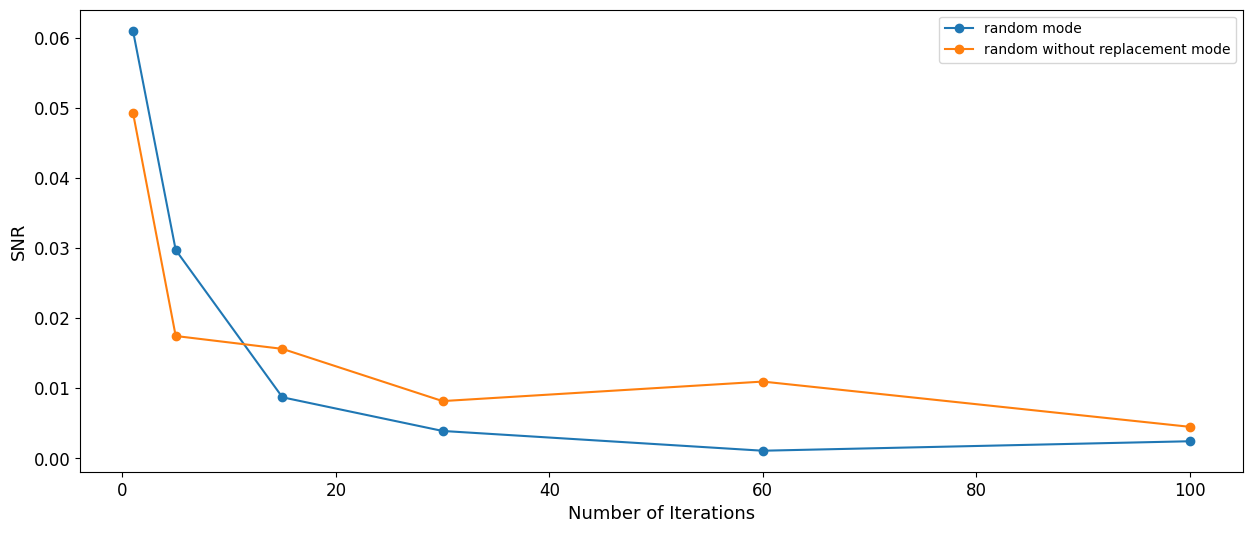

In [112]:
plt.figure(figsize=(15, 6))
variation_ratio1 = []
variation_ratio2 = []
for i, key in enumerate(list(SNR_random_no_replacement_arrays.keys())):
    coefs1 = np.polyfit(N_1D_array, SNR_random_arrays[key], deg=1)
    coefs2 = np.polyfit(N_1D_array, SNR_random_no_replacement_arrays[key], deg=1)
    fit1 = N_1D_array*coefs1[0] + coefs1[1]
    fit2 = N_1D_array*coefs2[0] + coefs2[1]
    variation_ratio1.append(coefs1[0])
    variation_ratio2.append(coefs2[0])

# plt.plot(np.arange(len(SNR_random_arrays))+1, variation_ratio1, marker='o', label='random mode')
# plt.plot(np.arange(len(SNR_random_no_replacement_arrays))+1, variation_ratio2, marker='o', label = 'random without replacement mode')

plt.plot(list(SNR_random_no_replacement_arrays.keys()), variation_ratio1, marker='o', label='random mode')
plt.plot(list(SNR_random_no_replacement_arrays.keys()), variation_ratio2, marker='o', label = 'random without replacement mode')

# list(SNR_random_no_replacement_arrays.keys())

plt.xlabel("Number of Iterations", fontsize=13)
plt.ylabel("SNR", fontsize=13)
plt.tick_params(axis='both', labelsize=12)
# plt.ylim(20, 25.5)
plt.legend()
plt.show()

From this plot, we can infer the `random without replacement` mode is apparently less stable and tends to converge slower than the `random` case.